# COMPSCI 3315 WORKSHOP
# <span style="color:#80CBC4">Green-screen point processing</span>

-------------
**Table of contents:**  

0. [Mount Google Drive to Google Colab](#mount_google_drive)  
1. [Load libraries](#load_libraries)  
2. [Load the given image](#load_given_image)
3. [Convert image from `RGB` format to `HSV` format](#convert_rgb2hsv)
4. [Morphopology](#morphopology)
5. [Compositing](#compositing)
6. [Extra parts - Post-processing](#extra_parts)
-------------

## <a id="mount_google_drive"></a> 0 - Mount Google Drive to Google Colab (If you use Google Colab for the Workshop)
Give Google Colab the permission to explore and use our Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Please upload the Workshop 1's images in the directory as shown below:  
My Drive  
&emsp;- Colab Notebooks  
&emsp; &emsp;- workshop1_imgs  
    

In [ ]:
IMG_PATH = "/content/drive/MyDrive/Colab Notebooks/workshop1_imgs"

If you use your own computer, please use this line below:

In [ ]:
IMG_PATH = "./imgs/"

## <a id="load_libraries"></a> 1 - Load libraries

In [ ]:
# Matplotlib is for visualization
import matplotlib.pyplot as plt
# Numpy is for computation
import numpy as np
# OpenCV (cv2) is for Computer Vision tools
import cv2
# os is for manipulating paths
import os

# Additional function to display image by using matplotlib

In [ ]:
def display(img, caption=''):
    # Show image using pyplot 
    plt.figure()
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()

In [ ]:
def display_with_figsize(img, figsize=(10,10), caption=''):
    # Show image using pyplot with chosen figsize
    plt.figure(figsize=figsize)
    # Convert from BGR to RGB
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(caption)
    plt.axis('off')
    plt.show()

## <a id="load_given_image"></a> 2 - Load the given image 

In [ ]:
img_name = "12.jpg"
img_file_path = os.path.join(IMG_PATH, img_name)

In [ ]:
img = cv2.imread(img_file_path)
display_with_figsize(img)
print(img.shape)

## <a id="convert_rgb2hsv"></a> 3 - Convert image from `RGB` format to `HSV` format.

Why we use HSV instead of RGB?  
https://dsp.stackexchange.com/questions/2687/why-do-we-use-the-hsv-colour-space-so-often-in-vision-and-image-processing

In [ ]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
print(img_hsv[1,1,0])

Reference: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.ncl.ucar.edu%2FDocument%2FGraphics%2FColorTables%2FMPL_hsv.shtml&psig=AOvVaw0HP7UC6T322SvGmvVng06s&ust=1678864826784000&source=images&cd=vfe&ved=0CAMQjB1qFwoTCJiS6v7w2v0CFQAAAAAdAAAAABAE

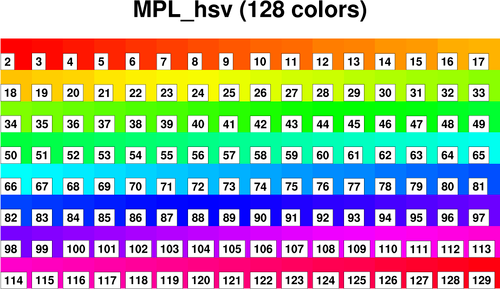

In [ ]:
mask1 = img_hsv[:,:,0] < 52 # the 3rd index in  img_hsv: 0 - hue, 1 - saturation, 2 - value
print(mask1.sum())

In [ ]:
mask1

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mask1, cmap="gray")

In [ ]:
mask2 = img_hsv[:,:,0] > 35
print(mask2.sum())

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mask2, cmap="gray")

In [ ]:
mask = mask1.astype("int") + mask2.astype("int")
human_mask = mask < 2

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(human_mask, cmap="gray")

## <a id="morphopology"></a> 4 - Morphopology
### Closing 

Section 3.3.3 in Richard Szeliski's Computer Vision: Algorithms and Applications, 2nd edition.

Reference: https://www.google.com/url?sa=i&url=https%3A%2F%2Fpyimagesearch.com%2F2021%2F04%2F28%2Fopencv-morphological-operations%2F&psig=AOvVaw2w2e-NjT0Q48AjrsVMBmLL&ust=1678865495349000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCODPz73z2v0CFQAAAAAdAAAAABAR

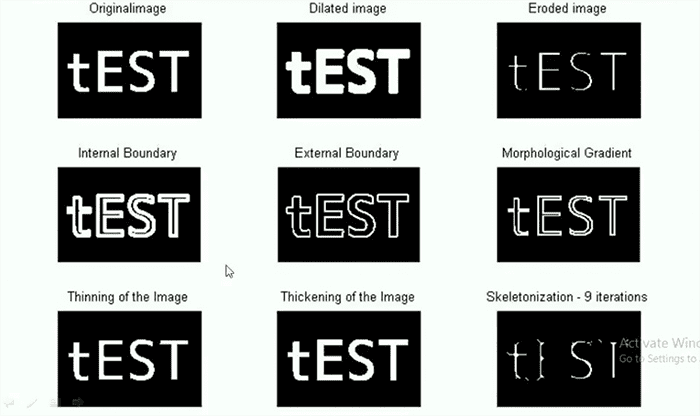

In [ ]:
kernel = np.ones((7, 7), dtype=np.uint8)
closing = cv2.morphologyEx(np.float32(human_mask), cv2.MORPH_CLOSE, kernel)
closing = closing.astype(np.uint8)
# display(closing * 255,"mask")
plt.figure(figsize=(15, 15))
plt.imshow(closing, cmap="gray")

In [ ]:
closing_mask = np.repeat(closing[:, :, np.newaxis], 3, axis=2)
print(closing_mask.shape)

In [ ]:
segmented_actor = img * closing_mask
display_with_figsize(segmented_actor, figsize=(15, 15), caption="Segmented Actor")

In [ ]:
segmented_actor.shape

## 5 - Compositing (The fun part)

In [ ]:
img_name = "UoA.jpeg"
background = cv2.imread(os.path.join(IMG_PATH, img_name))
resized_background = cv2.resize(background, (852, 480))
display_with_figsize(resized_background, figsize=(15, 15))
resized_background.shape

In [ ]:
segmented_background = (1 - closing_mask) * resized_background
display_with_figsize(segmented_background, figsize=(15, 15))

In [ ]:
result = segmented_actor + segmented_background
display_with_figsize(result, figsize=(15, 15))

## <a id="extra_parts"></a> Extra parts - Post-processing

The result looks kind of lame, right? How about we use Gaussian filter to make it better.

In [ ]:
blurred_result = cv2.GaussianBlur(result, (3,3), 0)
display_with_figsize(blurred_result, figsize=(15, 15))

# Some fun results

Note: To make result imaged look good, the original background image should have the same aspect ratio (w:h) as the foreground image (852:480). For example: (852:480), (1278:720), (1704:960), etc. You can use Paint to crop the background images first and use them in this notebook.

In [ ]:
def blend(segmented_actor, background, ksize=(3,3), figsize=(10, 10)):
    resized_background = cv2.resize(background, (852, 480))
    segmented_background = (1 - closing_mask) * resized_background
    result = segmented_actor + segmented_background
    blurred_result = cv2.GaussianBlur(result, ksize, 0)
    display_with_figsize(blurred_result, figsize)

In [ ]:
img_name = "underwater.png"
background = cv2.imread(os.path.join(IMG_PATH, img_name))
bg = cv2.imread(os.path.join(IMG_PATH, img_name))
blend(segmented_actor, bg, ksize=(3,3), figsize=(15, 15))

# Results from previous courses

In [ ]:
bg = cv2.imread('bts.jpg')
blend(segmented_actor, bg, ksize=(3,3), figsize=(10, 10))

In [ ]:
bg = cv2.imread('avenger.jpg')
blend(segmented_actor, bg, ksize=(3,3), figsize=(10, 10))

In [ ]:
bg = cv2.imread('yourname.jpg')
blend(segmented_actor, bg, ksize=(5,5), figsize=(10, 10))

In [ ]:
bg = cv2.imread('yibo.jpg')
blend(segmented_actor, bg, ksize=(3,3), figsize=(10, 10))

# It's your turn to play with this notebook!

You can find funny foregrounds by searching on Google: "green screen character", "green screen actor", "green screen anime", etc.